# Tutorial for Dynamic Obstacle Avoidance
This tutorial is based on following publications: 
> Huber, Lukas, Aude Billard, and Jean-Jacques E. Slotine. "Avoidance of Convex and Concave Obstacles with Convergence ensured through Contraction." IEEE Robotics and Automation Letters (2019). <br>
> Khansari-Zadeh, Seyed Mohammad, and Aude Billard. "A dynamical system approach to realtime obstacle avoidance." Autonomous Robots 32.4 (2012): 433-454.

The initial dynamical system $\vec f(\xi)$ is modulated to get the final dynamics $\dot \xi$:

$$ \dot{\xi} = M(\xi) \vec f(\xi) $$

with modulation matrix $M(\xi) = E(\xi)D(\xi)E(\xi)^{−1}$ composed of basis matrix $E(\xi)$ and the diagonal eigenvalue matrix $D(\xi )$. 

### Instructions - Notebook

This tutorial is based on jupyter notebook with python code at the backend. The source code can be found under 
https://github.com/hubernikus/dynamic_obstacle_avoidance_python

The notebook can be executed online with the link:
https://mybinder.org/v2/gh/hubernikus/dynamic_obstacle_avoidance_python/master

This notebook contains a mix of text and code. In order to execute the code, click on the containing field and press CTRL + RETURN. 

In [21]:
#import warnings
#warnings.filterwarnings('ignore')

import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))

from dynamic_obstacle_avoidance.visualization.widget_function_vectorfield import *

## Reference Point
The basis matrix $E(\xi)=\left[ {\vec r }(\xi) \;\; \vec e_1(\xi) \;\; .. \;\; \vec{e}_{d-1}(\xi) \right]$ decomposes the initial dynamical system into tangent directions $\vec e_i(\xi) \;\; i=1..d-1$ and reference direction $\vec r( \xi)$.

 The diagonal eigenvalue matrix $ D(\xi) =
 \textbf{diag} \left( \lambda_r(\xi) , \lambda_e(\xi) , .. , \lambda_{e}( \xi) \right) $  stretches the dynamical system along the tangent direction, and compresses along the reference direction.
This results in provable avoidance with convergence towards the attractor in environments with star-shaped and convex obstacles.

### Exercise 1
By running the script bellow you can observe an obstacle with center (black dot) and reference point (black cross). The visualization can be changed 
1. Change the center paramters $\xi_1$ and $\xi_2$ of the obstacle to modify the streamlines: <br>
1.1 Find a position of the obstacle where all streamlines avoid the obstacle above. <br>
1.2 Find a position of the obstacle where the obstacle splits the streamliens (two above, two bellow). <br>
1.3 What influence does the rotation $\Theta$ have on the behavior? <br>

2. Modify the center point of the obstacle (Direction and Exentricity): <br>
2.1 Find a pose of the obstacle; where by you only modifying the reference point the trajectoies avoid the obstacle avoidance, first all of them above and then all of them bellow.
2.2 What influence does the rotation $\Theta$ have on the behavior? <br>


In [2]:

exercise_referencePoint()


interactive(children=(FloatSlider(value=6.0, description='Obstacle center \\( x_1\\)', max=16.0, min=-16.0, st…


## Intersecting Obstacles
As could be observed in the previous section, the reference point determines in what direction the trajectories avoid the obstacles. This can now be used as an advantage for us when several obstacles intersect and form a concave star-shape. In such a case we can plase the reference point at the center of the intersection. This allows 


If you might have observed in the past interaction, the reference point decides the line where the DS is split and moves around the obstacle. This can now be extended to interscting obstacles, if they share a commond attractor they can 

### Exercise 2
The script bellow automatically finds a commond section for two obstacles. 
1. Choose 2 obstacles. Can you find one commond reference point for two obstacles, without having their body intersect (but only the safety maring)? Observe the vectorfields. <br>
2. Choose 4 obstacles. Can you make two pairs of two obstacle? Can you find a configuration with one common reference point? <br>
3. Choose 3 obstacles. Make a chain of obstacle (two different reference points). How does the vector field behave? <br>

In [6]:

exercise_intersectingObstacles()


Choose the number of obstacles:


interactive(children=(Dropdown(description='#', options=(2, 3, 4), value=2), Output()), _dom_classes=('widget-…

interactive(children=(Checkbox(value=False, description='Draw Vectorfield'), Button(description='Run Interact'…

## Dynamic Obstacle Avoidance
While the obstacle avoidance can be used for path planning in environments where everything can be reduced to star-shapes and inersecting obstacle. It has further the advantage of being fast and reactive evaluation. This allows agents to evaluate the algorithm on board in dynamically changing environements.

Bellow is a dynamic simulation where the attractor changes as soon as it is reached. Furthermore, you can give the obstacle a desired linear and angular velocity.

Comment: The present server interface allows only slow update rate, but if you run the algorithm offline you will get a much smoother simulation.



### Exercise 3
By clicking on the animation you can toggle pause and play.
1. Move obstacle 2 with linear velocity towards the attractor. What happens if it reaches it before the agent?<br>
2. Rotate obstacle 1. How does the agent behave if it is close to the surface? <br>
3. Intersect the obstacle such that the agent is moving towards the concave region. Does it get stuck? <br>


Interactive graphics are actived to execute the animation. Refresh the kernel before you running the other 
scripts again. 



<IPython.core.display.Javascript object>


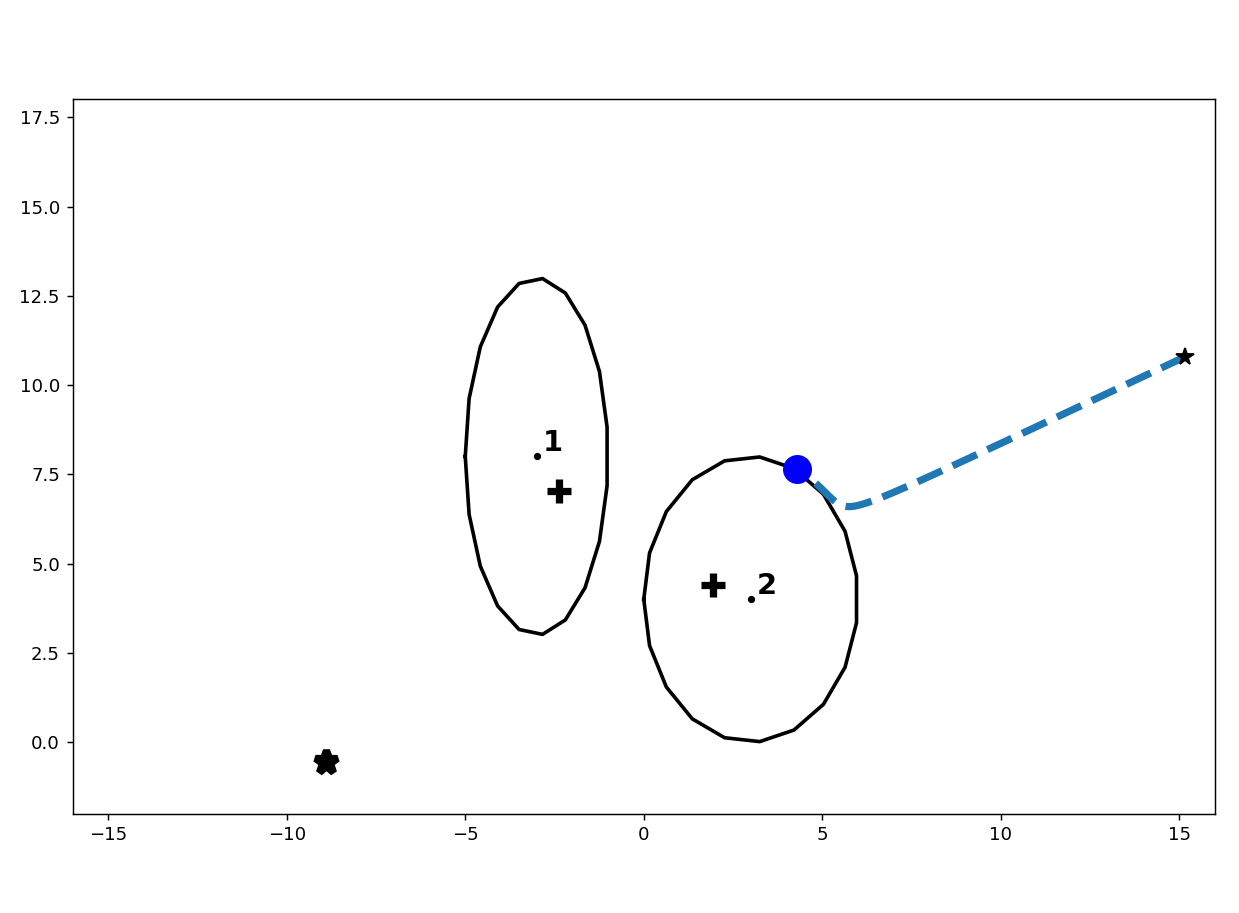

The video can be paused and continued by pressing onto the image.

Modify the parameters for the obstacle:


interactive(children=(Dropdown(description='#', options=(1, 2), value=1), FloatSlider(value=0.0, description='…

In [36]:

print("Interactive graphics are actived to execute the animation. Refresh the kernel before you running the other ")
print("scripts again. \n")
%matplotlib notebook
#%matplotlib tk # ACTIVATE offline for faster execution

exercise_dynamicModulation()
